# Collaborative Filtering

##from classical matrix factorization to NNs and then to GNNs

[check the Stanford course slides](http://web.stanford.edu/class/cs224w/slides/13-recsys.pdf)

Neural matrix factorization methods improve the conventional matrix factorization collaborative filtering
models replacing the MF interaction function of inner product with nonlinear neural networks.

But...
The model itself does not explicitly capture
graph structure
*   The graph structure is only implicitly captured in
the training objective.
*   Only the first-order graph structure (i.e.,
edges) is captured in the training objective.
*   High-order graph structure (e.g., n-hop paths
between two nodes) is not explicitly captured.


We want a model that…


*   explicitly captures graph structure (beyond
implicitly through the training objective)
*   captures high-order graph structure (beyond the
first-order edge connectivity structure)


GNNs are a natural approach to achieve both by explicitly
modeling graph structure using GNNs.

For example:
Neural Graph Collaborative Filtering and
LightGCN, a simplified and improved version of the former. (Related to SGC for scalable GNN.)

In traditional recommender models like
MF and neural collaborative filtering, IDs are
directly fed into an interaction layer (or operator) to achieve the prediction score.

In contrast, GNN based recommendation systems refine
the embeddings by propagating them on the user-item interaction
graph. This leads to more effective embeddings for recommendation, since the embedding refinement step explicitly injects collaborative signal into embeddings.

**But these methods still don't use  node attributes (e.g. text, images)**

These methods only
investigate the mutual interactions between users and items, ignoring the within-entity contextual knowledge, i.e. the collaborative
signal within each type of entities, which can be acquired from the
entity side information. To capture such within-entity contextual
knowledge, we can use [GNNs](https://arxiv.org/pdf/2107.03936.pdf) to pre-train the entity representations using the side information of both the users and items,
so that the independent knowledge of each type of entities can be
captured from the entity relations.

###Plain matrix factorization (considers only user-item interactions but no features)

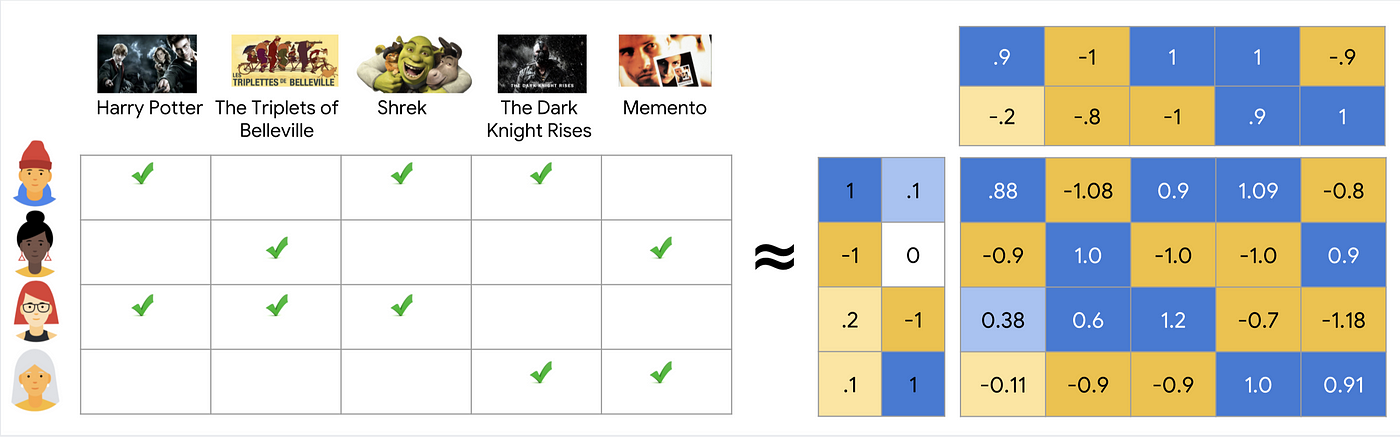

###[Matrix-factorization as a shallow neural network model](https://developer.nvidia.com/blog/using-neural-networks-for-your-recommender-system/)

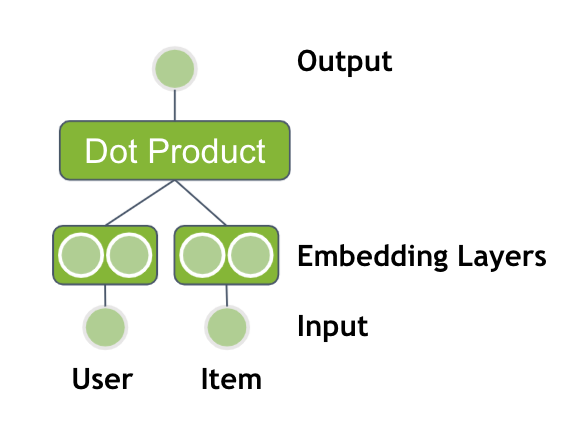

###...as deep models

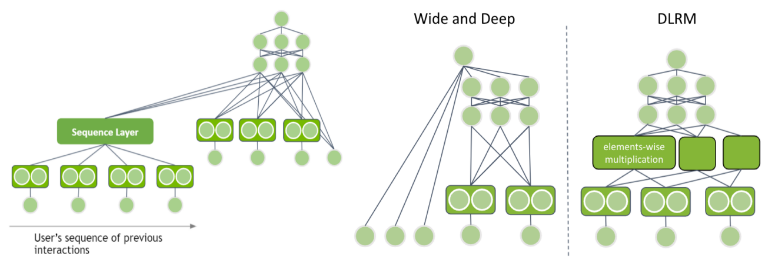

###...[adding features](https://www.tensorflow.org/recommenders/examples/featurization)

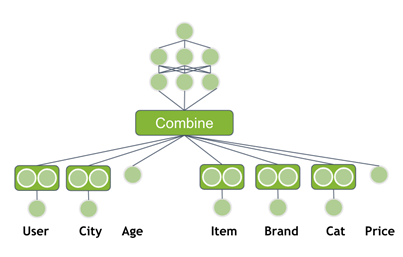

## ... [and as graph](https://arxiv.org/pdf/2002.02126.pdf)


##Exploiting the user-item (heterogeneous) interaction graph to infer user preference


#### [LightGCN](https://arxiv.org/pdf/2002.02126.pdf) will further "diffuse" the MF embeddings (which consider only first-order user-item interations)


*   [Tutorial](https://medium.com/@jn2279/)
*   [Vanilla code](https://github.com/maciejkula/triplet_recommendations_keras)

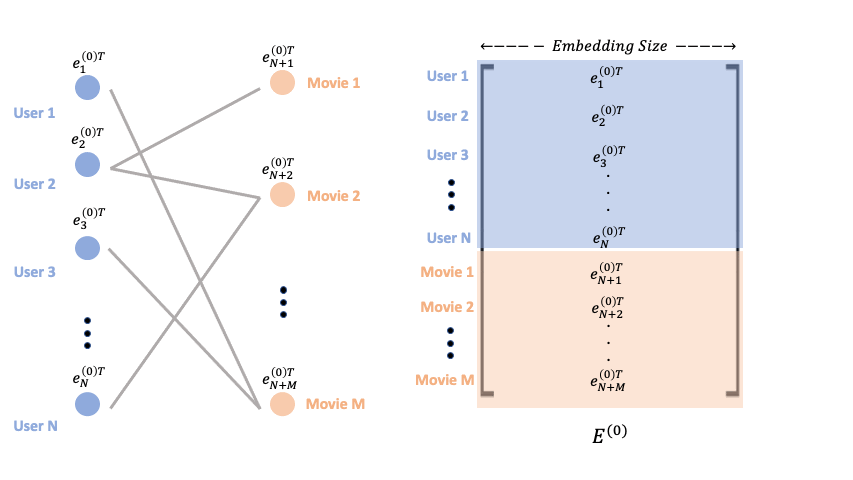

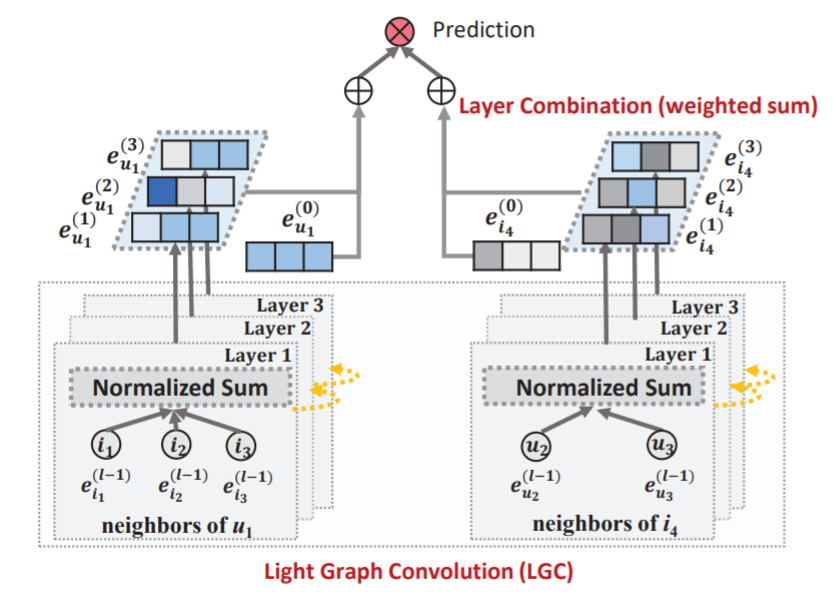

## Example

[This example](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) demonstrates the first approach described for
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

## First, load the data and apply preprocessing


In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


978202/978202 [==============================] - 1s 1us/step
Extracting all the files now...
Done!


First, need to perform some preprocessing to encode users and movies as integer indices.


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


## Prepare training and validation data


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

User vs item iteractions (user-movie pairs)

In [ ]:
print(x_val[:5])
print(y_val[:5])

[[ 324 1018]
 [   0    2]
 [ 103 4229]
 [ 440 7727]
 [ 473 8185]]
[0.55555556 0.77777778 0.55555556 1.         0.55555556]


The embeddings are learned such that the dot product of user and item embeddings
is a good approximation of the interaction matrix.
This can be performed through matrix factorization techniques or we can train a NN for that.

## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

## Train the model based on the data split


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.6362 - val_loss: 0.6205
Epoch 2/5
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6133 - val_loss: 0.6185
Epoch 3/5
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6086 - val_loss: 0.6146
Epoch 4/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6076 - val_loss: 0.6137
Epoch 5/5
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6072 - val_loss: 0.6147


In [ ]:
model.summary()

Model: "recommender_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  30500     
                                                                 
 embedding_5 (Embedding)     multiple                  610       
                                                                 
 embedding_6 (Embedding)     multiple                  486200    
                                                                 
 embedding_7 (Embedding)     multiple                  9724      
                                                                 
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


## Plot training and validation loss


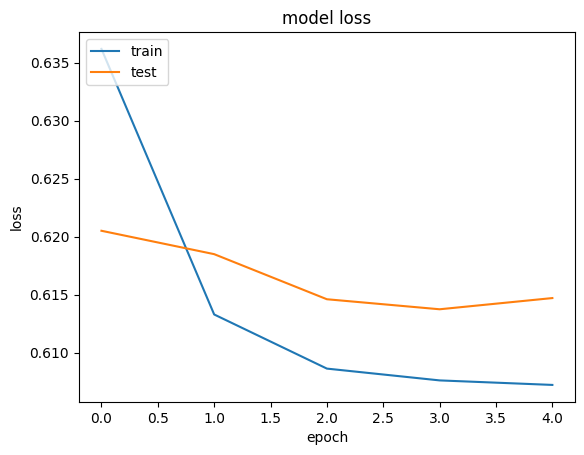

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Show top 10 movie recommendations to a user


In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


295/295 [==============================] - 1s 1ms/step
Showing recommendations for user: 453
Movies with high ratings from user
--------------------------------
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Femme Nikita, La (Nikita) (1990) : Action|Crime|Romance|Thriller
Being John Malkovich (1999) : Comedy|Drama|Fantasy
Sister Act (1992) : Comedy|Crime
Legend of Drunken Master, The (Jui kuen II) (1994) : Action|Comedy
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Maltese Falcon, The (1941) : Film-Noir|Mystery
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
One Flew Over the Cuckoo's Nest (1975) : Drama
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Lawrence of Arabia 

###But those are still "shallow" embeddings: we are using only user-item interactions and not user and movie features:

In [ ]:
{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}

[look here for an example of deep embedding of features](https://www.tensorflow.org/recommenders/examples/featurization)

[and here for graph based recommender systems](https://github.com/microsoft/recommenders/blob/main/examples/02_model_collaborative_filtering/lightgcn_deep_dive.ipynb)